In [1]:
import pandas as pd
from sudulunu.helpers import pp, make_num, dumper
import os 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def combine_from_folder(pathos):
  
  listo = []
  
  fillos = os.listdir(pathos)
  fillos = [pathos + '/' + x for x in fillos if '.csv' in x]
  # print(fillos)

  city_dicto = {}
  for city in fillos:
    city_dicto[city] = city.replace("data/", '').replace('.csv', '')
  
  # print(city_dicto)

  for fillo in fillos:
    inter = pd.read_csv(fillo)

    temp_col = [x for x in inter.columns.tolist() if 'time' in x.lower()]
    inter.rename(columns={temp_col[0]: "Time"}, inplace=True)
    inter['City'] = city_dicto[fillo]

    listo.append(inter)

  cat = pd.concat(listo)

  return cat

data = combine_from_folder('data')

In [3]:
df = data.copy()
# 'Time', 'Temp (°C)', 'Feels Like (°C)', 'Humidity(%)', 
# 'Wind Direction', 'Wind Speed (km/h) (knots)', 'Wind Gust (km/h) (knots)', 
# 'Pressure (hPa)', 'Rainfall since 9 am (mm)', 'Date', 'City'

df = df[['Time', 'Temp (°C)', 'Date','City']]
# df = df[['Time', 'Feels Like (°C)', 'Date','City']]

# pp(df)

### Only keep the whole hour data
df['Time'] = pd.to_datetime(df['Time'], format='%I:%M %p')
# df = df[df['Time'].dt.minute.eq(0) & df['Time'].dt.second.eq(0) & df['Time'].dt.hour.gt(9)]
df = df[df['Time'].dt.minute.eq(0) & df['Time'].dt.second.eq(0)]

In [4]:
listo = []


df = make_num(df, 'Temp (°C)')
pp(df)

                   Time  Temp (°C)        Date      City
0   1900-01-01 06:00:00       15.0  2023-03-10    Hobart
2   1900-01-01 07:00:00       14.9  2023-03-10    Hobart
5   1900-01-01 01:00:00       14.6  2023-03-10    Hobart
7   1900-01-01 02:00:00       14.7  2023-03-10    Hobart
9   1900-01-01 00:00:00       14.9  2023-03-10    Hobart
..                  ...        ...         ...       ...
794 1900-01-01 23:00:00       21.8  2023-02-21  Brisbane
797 1900-01-01 13:00:00       28.8  2023-02-21  Brisbane
799 1900-01-01 14:00:00       28.7  2023-02-21  Brisbane
801 1900-01-01 15:00:00       28.2  2023-02-21  Brisbane
803 1900-01-01 16:00:00       27.5  2023-02-21  Brisbane

[2811 rows x 4 columns]
['Time', 'Temp (°C)', 'Date', 'City']


       index  >10c range  Total days  Percentage
6   Brisbane         0.0        17.0        0.00
1     Sydney         4.0        17.0       23.53
0     Hobart         5.0        17.0       29.41
3  Melbourne         5.0        17.0       29.41
5   Adelaide         6.0        17.0       35.29
2   Canberra        12.0        17.0       70.59
4      Perth        12.0        17.0       70.59
['index', '>10c range', 'Total days', 'Percentage']


<AxesSubplot: xlabel='index', ylabel='Percentage'>

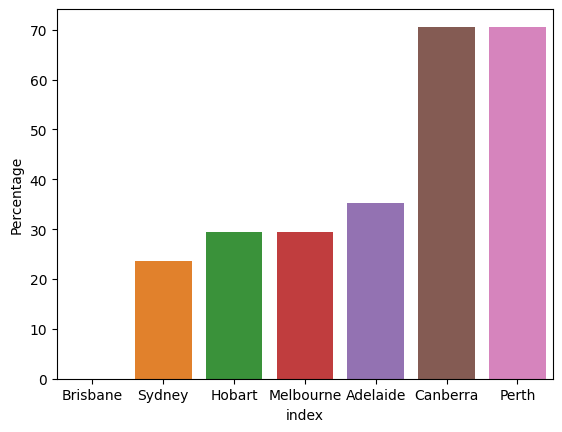

In [5]:
zdf = df.copy()
zdf['Time'] = pd.to_datetime(zdf['Time'])

zdf['Hour'] = zdf['Time'].dt.hour

zdf = zdf.loc[(zdf['Hour'] >= 7) & (zdf['Hour'] <= 19)]

# pp(zdf)

records = []

dicto = {}


for city in zdf['City'].unique().tolist():

    city_counter = 0
    city_totes = 0

    inter = zdf.loc[zdf['City'] == city].copy()

    for day in inter['Date'].unique().tolist():

        bet = inter.loc[inter['Date'] == day].copy()

        # print(bet['Hour'].max())

        ### Ensure we are only getting full days
        if bet['Hour'].max() == 19:
        
            rangeo = bet['Temp (°C)'].max() - bet['Temp (°C)'].min()

            record = {"City": city, "Date": day, "Max":bet['Temp (°C)'].max(), "Min": bet['Temp (°C)'].min(),  "Range": int(rangeo)}
            records.append(record)

            city_totes += 1

            if rangeo >= 10:
                city_counter += 1

    dicto[city] = {">10c range": int(city_counter), "Total days": int(city_totes) ,"Percentage" : round((city_counter / city_totes ) * 100,2)}
cat = pd.DataFrame.from_records(records)

res = pd.DataFrame.from_dict(dicto)

# pp(res)

# pp(cat)
# print(dicto)

res = res.T.reset_index()
res.sort_values(by=['Percentage'], inplace=True)
pp(res)

sns.barplot(data=res, x="index", y="Percentage")


23
Time         1900-01-01 17:00:00
Temp (°C)                   17.8
Date                  2023-03-09
City                      Hobart
Hour                          17
Name: 57, dtype: object
Time         1900-01-01 16:00:00
Temp (°C)                   17.8
Date                  2023-03-09
City                      Hobart
Hour                          16
Name: 59, dtype: object
Time         1900-01-01 17:00:00
Temp (°C)                   15.3
Date                  2023-03-08
City                      Hobart
Hour                          17
Name: 87, dtype: object
Time         1900-01-01 14:00:00
Temp (°C)                   19.2
Date                  2023-03-07
City                      Hobart
Hour                          14
Name: 166, dtype: object
Time         1900-01-01 14:00:00
Temp (°C)                   23.2
Date                  2023-03-06
City                      Hobart
Hour                          14
Name: 257, dtype: object
Time         1900-01-01 17:00:00
Temp (°C)        

<AxesSubplot: xlabel='Latest', ylabel='City'>

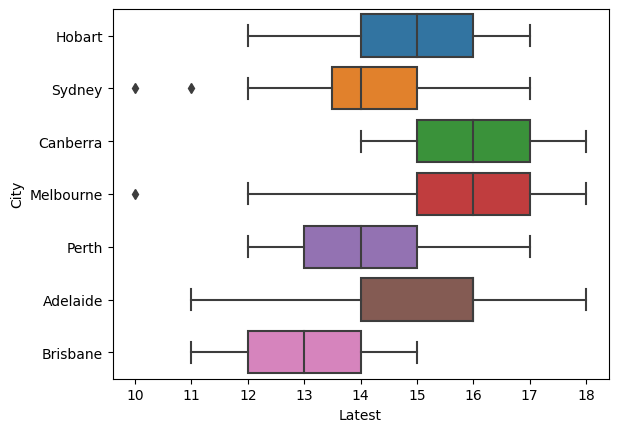

In [6]:
### Figure out what hottest time of day is

ddf = df.copy()

ddf['Time'] = pd.to_datetime(ddf['Time'])

ddf['Hour'] = ddf['Time'].dt.hour

print(ddf['Hour'].max())

records = []

dicto = {}

for city in ddf['City'].unique().tolist():

    inter = ddf.loc[ddf['City'] == city].copy()

    for day in inter['Date'].unique().tolist():

        bet = inter.loc[inter['Date'] == day].copy()

        if bet['Hour'].max() == 23:

            maxxer = bet.loc[bet['Temp (°C)'] == bet['Temp (°C)'].max()].copy()

            for index, row in maxxer.iterrows():
                print(row)

                houro = row['Hour']


                record = {"City": city, "Date": day, "Latest": houro}
                records.append(record)


cat = pd.DataFrame.from_records(records)

pp(cat)

sns.boxplot(data=cat, x="Latest", y="City")
